In [1]:
import torch
# torch.cuda.is_available()
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)

import matplotlib.pyplot as plt
import skimage
from scipy.stats import mode
import numpy as np

/home/twhit/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Images

/tmp/ipykernel_2994827/3318400919.py:24: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  modes[i] = mode(image[image<20]).mode


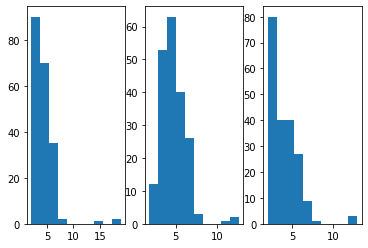

In [2]:
# Background estimation
num_images = 200

modes = np.zeros(num_images)
means = np.zeros(num_images)
medians = np.zeros(num_images)

for i in range(num_images):
    # Read in image
    image = skimage.io.imread(f'../data/BBBC039/images_raw/image{i}.tif')
    
    # Downscale by factor of 2
    image = skimage.transform.downscale_local_mean(image, factors = (2,2))
    
    # Normalize and convert to 8-bit range
    low = np.percentile(image, 0.01)
    high = np.percentile(image, 99.99)
    image = np.minimum(image, high)
    image = np.maximum(image, low)
    image = (image - low) / (high - low)
    image = skimage.img_as_ubyte(image)
    
    # Compute mode, median, and mean under some reasonable threshold
    modes[i] = mode(image[image<20]).mode
    means[i] = image[image<20].mean()
    medians[i] = np.median(image[image<20])

fig,ax=plt.subplots(1,3)
_ = ax[0].hist(modes.flatten())
_ = ax[1].hist(means.flatten())
_ = ax[2].hist(medians.flatten())

In [3]:
num_images = 200
dim = 256
images = torch.zeros(num_images, dim, dim)

for i in range(num_images):
    # Read in image
    image = skimage.io.imread(f'../data/BBBC039/images_raw/image{i}.tif')
    
    # Downscale by factor of 2
    image = skimage.transform.downscale_local_mean(image, factors = (2,2))
    
    # Normalize and convert to 8-bit range
    low = np.percentile(image, 0)
    high = np.percentile(image, 99.99)
    image = np.minimum(image, high)
    image = np.maximum(image, low)
    image = (image - low) / (high - low)
    image = skimage.img_as_ubyte(image)
    
    # Crop image
    image = image[:dim,:dim]
    
    images[i] = torch.from_numpy(np.array(image, dtype = np.float64)[:dim,:dim])

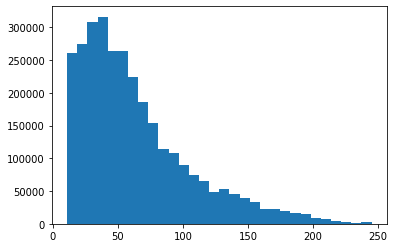

In [4]:
# Fluorescence empirical distribution
background = 10
_ = plt.hist((images[images>(2*background)] - background).flatten().cpu().numpy(), bins = 30)

### Masks

In [5]:
true_counts = torch.zeros(num_images)
masks = torch.zeros(num_images, 2*dim, 2*dim)

for i in range(num_images):
    mask = skimage.io.imread(f'../data/BBBC039/masks_raw/mask{i}.png')
    mask = mask[:(2*dim),:(2*dim),0]
    masks[i] = torch.tensor(skimage.morphology.label(mask))
    true_counts[i] = len(torch.unique(masks[i])) - 1

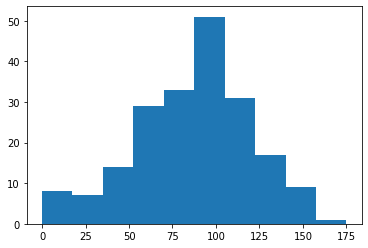

In [6]:
# True counts per pixel
_ = plt.hist(true_counts.cpu().numpy())

### Save tensors

In [7]:
torch.save(images, '../data/BBBC039/images.pt')
torch.save(masks, '../data/BBBC039/masks.pt')
torch.save(true_counts, '../data/BBBC039/true_counts.pt')